In [1]:
%load_ext autoreload
%autoreload 2

import math
import copy
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from torchvision.datasets import *
from torchvision.transforms import *
from torch.utils.data import DataLoader
from utils import *
from model import *
from evaluation import *
from train import *
from pruning import *
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset Preparation

In [2]:
image_size = 32
transforms = {
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
    ]),
    "test": ToTensor(),
}
dataset = {}
for split in ["train", "test"]:
  dataset[split] = CIFAR10(
    root="/home/arun/Desktop/MTP-Quantization-HAWQ/data/cifar10",
    train=(split == "train"),
    download=True,
    transform=transforms[split],
  )
dataloader = {}
for split in ['train', 'test']:
  dataloader[split] = DataLoader(
    dataset[split],
    batch_size=512,
    shuffle=(split == 'train'),
    num_workers=0,
    pin_memory=True,
  )

Files already downloaded and verified
Files already downloaded and verified


In [3]:
data_root = '/srv/datasets/'
traindir = os.path.join(data_root, 'train')
valdir = os.path.join(data_root, 'val')

# preprocessing
input_size = 224
imagenet_tran_train = [
    RandomResizedCrop(input_size, scale=(0.2, 1.0)),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
imagenet_tran_test = [
    Resize(int(input_size / 0.875)),
    CenterCrop(input_size),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

train_loader = torch.utils.data.DataLoader(
    ImageFolder(traindir, Compose(imagenet_tran_train)),
    batch_size=256, shuffle=True,
    num_workers=1, pin_memory=True, sampler=None)

val_loader = torch.utils.data.DataLoader(
    ImageFolder(valdir, Compose(imagenet_tran_test)),
    batch_size=256, shuffle=False,
    num_workers=1, pin_memory=True)
n_class = 1000

# dataset = {}
# for split in ["train", "test"]:
#   dataset[split] = CIFAR10(
#     root="/home/arun/Desktop/MTP-Quantization-HAWQ/data/cifar10",
#     train=(split == "train"),
#     download=True,
#     transform=transforms[split],
#   )
dataloader = {
    'train': train_loader,
    'test': val_loader
}

### Prepare the model

In [4]:

from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights, vgg16_bn, VGG16_BN_Weights, resnet18, ResNet18_Weights, resnet50, ResNet50_Weights
# checkpoint_url = "https://hanlab18.mit.edu/files/course/labs/vgg.cifar.pretrained.pth"
# checkpoint = torch.load(download_url(checkpoint_url, model_dir="model_dir"), map_location="cpu")
model = vgg16_bn(VGG16_BN_Weights)
# print(f"=> loading checkpoint '{checkpoint_url}'")
# model.load_state_dict(checkpoint['state_dict'])
# recover_model = lambda: model.load_state_dict(checkpoint['state_dict'])

/usr/lib/python3.10/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/lib/python3.10/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
dense_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
dense_model_size = get_model_size(model)

In [6]:
Byte = 8
KiB = 1024 * Byte
MiB = 1024 * KiB
GiB = 1024 * MiB
# print(f"dense model has accuracy={dense_model_accuracy:.2f}%")
# print(f"dense model has size={dense_model_size/MiB:.2f} MiB")

In [ ]:
def plot_weight_distribution(model, bins=256, count_nonzero_only=False):
    fig, axes = plt.subplots(3,3, figsize=(10, 6))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            if count_nonzero_only:
                param_cpu = param.detach().view(-1).cpu()
                param_cpu = param_cpu[param_cpu != 0].view(-1)
                ax.hist(param_cpu, bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            else:
                ax.hist(param.detach().view(-1).cpu(), bins=bins, density=True,
                        color = 'blue', alpha = 0.5)
            ax.set_xlabel(name)
            ax.set_ylabel('density')
            plot_index += 1
    fig.suptitle('Histogram of Weights')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_weight_distribution(model)

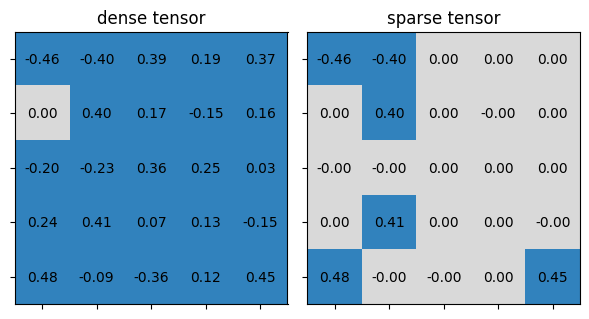

* Test fine_grained_prune()
    target sparsity: 0.75
        sparsity before pruning: 0.04
        sparsity after pruning: 0.76
        sparsity of pruning mask: 0.76
* Test passed.


In [43]:
def test_fine_grained_prune(
    test_tensor=torch.tensor([[-0.46, -0.40, 0.39, 0.19, 0.37],
                              [0.00, 0.40, 0.17, -0.15, 0.16],
                              [-0.20, -0.23, 0.36, 0.25, 0.03],
                              [0.24, 0.41, 0.07, 0.13, -0.15],
                              [0.48, -0.09, -0.36, 0.12, 0.45]]),
    test_mask=torch.tensor([[True, True, False, False, False],
                            [False, True, False, False, False],
                            [False, False, False, False, False],
                            [False, True, False, False, False],
                            [True, False, False, False, True]]),
    target_sparsity=0.75, target_nonzeros=None):
    def plot_matrix(tensor, ax, title):
        ax.imshow(tensor.cpu().numpy() == 0, vmin=0, vmax=1, cmap='tab20c')
        ax.set_title(title)
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        for i in range(tensor.shape[1]):
            for j in range(tensor.shape[0]):
                text = ax.text(j, i, f'{tensor[i, j].item():.2f}',
                                ha="center", va="center", color="k")

    test_tensor = test_tensor.clone()
    fig, axes = plt.subplots(1,2, figsize=(6, 10))
    ax_left, ax_right = axes.ravel()
    plot_matrix(test_tensor, ax_left, 'dense tensor')

    sparsity_before_pruning = get_sparsity(test_tensor)
    mask = fine_grained_prune(test_tensor, target_sparsity)
    sparsity_after_pruning = get_sparsity(test_tensor)
    sparsity_of_mask = get_sparsity(mask)

    plot_matrix(test_tensor, ax_right, 'sparse tensor')
    fig.tight_layout()
    plt.show()

    print('* Test fine_grained_prune()')
    print(f'    target sparsity: {target_sparsity:.2f}')
    print(f'        sparsity before pruning: {sparsity_before_pruning:.2f}')
    print(f'        sparsity after pruning: {sparsity_after_pruning:.2f}')
    print(f'        sparsity of pruning mask: {sparsity_of_mask:.2f}')

    if target_nonzeros is None:
        if test_mask.equal(mask):
            print('* Test passed.')
        else:
            print('* Test failed.')
    else:
        if mask.count_nonzero() == target_nonzeros:
            print('* Test passed.')
        else:
            print('* Test failed.')
test_fine_grained_prune()

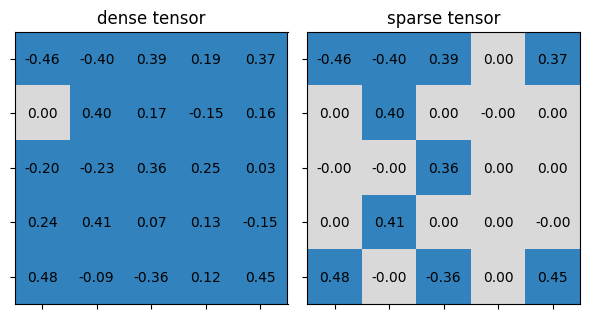

* Test fine_grained_prune()
    target sparsity: 0.60
        sparsity before pruning: 0.04
        sparsity after pruning: 0.60
        sparsity of pruning mask: 0.60
* Test passed.


In [44]:
target_sparsity = 0.6
test_fine_grained_prune(target_sparsity=target_sparsity, target_nonzeros=10)

### Sensivity Scan

In [45]:
@torch.no_grad()
def sensitivity_scan(model, dataloader, scan_step=0.1, scan_start=0.4, scan_end=1.0, verbose=True):
    sparsities = np.arange(start=scan_start, stop=scan_end, step=scan_step)
    accuracies = []
    named_conv_weights = [(name, param) for (name, param) \
                          in model.named_parameters() if param.dim() > 1]
    for i_layer, (name, param) in enumerate(named_conv_weights):
        param_clone = param.detach().clone()
        accuracy = []
        for sparsity in tqdm(sparsities, desc=f'scanning {i_layer}/{len(named_conv_weights)} weight - {name}'):
            fine_grained_prune(param.detach(), sparsity=sparsity)
            acc = evaluate(model, dataloader, device=DEVICE, verbose=False)
            if verbose:
                print(f'\r    sparsity={sparsity:.2f}: accuracy={acc:.2f}%', end='')
            # restore
            param.copy_(param_clone)
            accuracy.append(acc)
        if verbose:
            print(f'\r    sparsity=[{",".join(["{:.2f}".format(x) for x in sparsities])}]: accuracy=[{", ".join(["{:.2f}%".format(x) for x in accuracy])}]', end='')
        accuracies.append(accuracy)
    return sparsities, accuracies

In [46]:
sparsities, accuracies = sensitivity_scan(model, dataloader['test'], scan_step=0.1, scan_start=0.4, scan_end=1.0)

scanning 0/16 weight - features.0.weight:  17%|█▋        | 1/6 [02:00<10:03, 120.67s/it]

    sparsity=0.40: accuracy=73.37%

scanning 0/16 weight - features.0.weight:  33%|███▎      | 2/6 [04:01<08:01, 120.49s/it]

    sparsity=0.50: accuracy=73.37%

scanning 0/16 weight - features.0.weight:  50%|█████     | 3/6 [06:02<06:02, 120.78s/it]

    sparsity=0.60: accuracy=73.41%

scanning 0/16 weight - features.0.weight:  67%|██████▋   | 4/6 [08:03<04:01, 120.88s/it]

    sparsity=0.70: accuracy=73.28%

scanning 0/16 weight - features.0.weight:  83%|████████▎ | 5/6 [10:05<02:01, 121.22s/it]

    sparsity=0.80: accuracy=72.58%

scanning 0/16 weight - features.0.weight: 100%|██████████| 6/6 [12:06<00:00, 121.10s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.37%, 73.37%, 73.41%, 73.28%, 72.58%, 63.75%]

scanning 1/16 weight - features.3.weight:  17%|█▋        | 1/6 [01:55<09:39, 115.93s/it]

    sparsity=0.40: accuracy=73.38%

scanning 1/16 weight - features.3.weight:  33%|███▎      | 2/6 [03:51<07:42, 115.66s/it]

    sparsity=0.50: accuracy=73.37%

scanning 1/16 weight - features.3.weight:  50%|█████     | 3/6 [05:46<05:46, 115.38s/it]

    sparsity=0.60: accuracy=73.32%

scanning 1/16 weight - features.3.weight:  67%|██████▋   | 4/6 [07:43<03:51, 115.89s/it]

    sparsity=0.70: accuracy=73.37%

scanning 1/16 weight - features.3.weight:  83%|████████▎ | 5/6 [09:38<01:55, 115.80s/it]

    sparsity=0.80: accuracy=73.21%

scanning 1/16 weight - features.3.weight: 100%|██████████| 6/6 [11:34<00:00, 115.67s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.38%, 73.37%, 73.32%, 73.37%, 73.21%, 72.42%]

scanning 2/16 weight - features.7.weight:  17%|█▋        | 1/6 [01:55<09:39, 115.97s/it]

    sparsity=0.40: accuracy=73.43%

scanning 2/16 weight - features.7.weight:  33%|███▎      | 2/6 [03:50<07:41, 115.40s/it]

    sparsity=0.50: accuracy=73.31%

scanning 2/16 weight - features.7.weight:  50%|█████     | 3/6 [05:46<05:46, 115.61s/it]

    sparsity=0.60: accuracy=73.04%

scanning 2/16 weight - features.7.weight:  67%|██████▋   | 4/6 [07:44<03:53, 116.59s/it]

    sparsity=0.70: accuracy=71.05%

scanning 2/16 weight - features.7.weight:  83%|████████▎ | 5/6 [09:40<01:56, 116.36s/it]

    sparsity=0.80: accuracy=61.39%

scanning 2/16 weight - features.7.weight: 100%|██████████| 6/6 [11:36<00:00, 116.05s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.43%, 73.31%, 73.04%, 71.05%, 61.39%, 32.74%]

scanning 3/16 weight - features.10.weight:  17%|█▋        | 1/6 [01:56<09:43, 116.71s/it]

    sparsity=0.40: accuracy=73.33%

scanning 3/16 weight - features.10.weight:  33%|███▎      | 2/6 [03:52<07:45, 116.26s/it]

    sparsity=0.50: accuracy=73.32%

scanning 3/16 weight - features.10.weight:  50%|█████     | 3/6 [05:48<05:47, 115.90s/it]

    sparsity=0.60: accuracy=73.02%

scanning 3/16 weight - features.10.weight:  67%|██████▋   | 4/6 [07:44<03:52, 116.09s/it]

    sparsity=0.70: accuracy=71.91%

scanning 3/16 weight - features.10.weight:  83%|████████▎ | 5/6 [09:43<01:57, 117.31s/it]

    sparsity=0.80: accuracy=67.24%

scanning 3/16 weight - features.10.weight: 100%|██████████| 6/6 [11:47<00:00, 117.91s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.33%, 73.32%, 73.02%, 71.91%, 67.24%, 43.21%]

scanning 4/16 weight - features.14.weight:  17%|█▋        | 1/6 [02:01<10:07, 121.42s/it]

    sparsity=0.40: accuracy=73.25%

scanning 4/16 weight - features.14.weight:  33%|███▎      | 2/6 [04:02<08:03, 120.93s/it]

    sparsity=0.50: accuracy=73.05%

scanning 4/16 weight - features.14.weight:  50%|█████     | 3/6 [06:03<06:03, 121.24s/it]

    sparsity=0.60: accuracy=72.78%

scanning 4/16 weight - features.14.weight:  67%|██████▋   | 4/6 [08:05<04:02, 121.48s/it]

    sparsity=0.70: accuracy=71.43%

scanning 4/16 weight - features.14.weight:  83%|████████▎ | 5/6 [10:06<02:01, 121.24s/it]

    sparsity=0.80: accuracy=69.04%

scanning 4/16 weight - features.14.weight: 100%|██████████| 6/6 [12:07<00:00, 121.29s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.25%, 73.05%, 72.78%, 71.43%, 69.04%, 55.22%]

scanning 5/16 weight - features.17.weight:  17%|█▋        | 1/6 [01:59<09:59, 119.98s/it]

    sparsity=0.40: accuracy=73.17%

scanning 5/16 weight - features.17.weight:  33%|███▎      | 2/6 [03:59<07:57, 119.47s/it]

    sparsity=0.50: accuracy=73.06%

scanning 5/16 weight - features.17.weight:  50%|█████     | 3/6 [05:58<05:58, 119.43s/it]

    sparsity=0.60: accuracy=72.74%

scanning 5/16 weight - features.17.weight:  67%|██████▋   | 4/6 [08:00<04:00, 120.45s/it]

    sparsity=0.70: accuracy=71.50%

scanning 5/16 weight - features.17.weight:  83%|████████▎ | 5/6 [10:01<02:00, 120.65s/it]

    sparsity=0.80: accuracy=66.81%

scanning 5/16 weight - features.17.weight: 100%|██████████| 6/6 [12:02<00:00, 120.37s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.17%, 73.06%, 72.74%, 71.50%, 66.81%, 22.05%]

scanning 6/16 weight - features.20.weight:  17%|█▋        | 1/6 [02:01<10:06, 121.21s/it]

    sparsity=0.40: accuracy=73.32%

scanning 6/16 weight - features.20.weight:  33%|███▎      | 2/6 [04:01<08:02, 120.61s/it]

    sparsity=0.50: accuracy=73.15%

scanning 6/16 weight - features.20.weight:  50%|█████     | 3/6 [06:02<06:02, 120.72s/it]

    sparsity=0.60: accuracy=72.65%

scanning 6/16 weight - features.20.weight:  67%|██████▋   | 4/6 [08:03<04:01, 120.82s/it]

    sparsity=0.70: accuracy=71.45%

scanning 6/16 weight - features.20.weight:  83%|████████▎ | 5/6 [10:03<02:00, 120.74s/it]

    sparsity=0.80: accuracy=64.32%

scanning 6/16 weight - features.20.weight: 100%|██████████| 6/6 [12:05<00:00, 120.84s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.32%, 73.15%, 72.65%, 71.45%, 64.32%, 24.32%]

scanning 7/16 weight - features.24.weight:  17%|█▋        | 1/6 [02:02<10:13, 122.71s/it]

    sparsity=0.40: accuracy=73.16%

scanning 7/16 weight - features.24.weight:  33%|███▎      | 2/6 [03:59<07:57, 119.39s/it]

    sparsity=0.50: accuracy=72.67%

scanning 7/16 weight - features.24.weight:  50%|█████     | 3/6 [05:56<05:54, 118.07s/it]

    sparsity=0.60: accuracy=71.45%

scanning 7/16 weight - features.24.weight:  67%|██████▋   | 4/6 [07:52<03:54, 117.20s/it]

    sparsity=0.70: accuracy=69.24%

scanning 7/16 weight - features.24.weight:  83%|████████▎ | 5/6 [09:48<01:56, 116.78s/it]

    sparsity=0.80: accuracy=61.81%

scanning 7/16 weight - features.24.weight: 100%|██████████| 6/6 [11:46<00:00, 117.82s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.16%, 72.67%, 71.45%, 69.24%, 61.81%, 18.76%]

scanning 8/16 weight - features.27.weight:  17%|█▋        | 1/6 [01:59<09:57, 119.43s/it]

    sparsity=0.40: accuracy=73.23%

scanning 8/16 weight - features.27.weight:  33%|███▎      | 2/6 [03:57<07:53, 118.41s/it]

    sparsity=0.50: accuracy=73.09%

scanning 8/16 weight - features.27.weight:  50%|█████     | 3/6 [05:52<05:50, 116.88s/it]

    sparsity=0.60: accuracy=72.57%

scanning 8/16 weight - features.27.weight:  67%|██████▋   | 4/6 [07:48<03:52, 116.50s/it]

    sparsity=0.70: accuracy=71.08%

scanning 8/16 weight - features.27.weight:  83%|████████▎ | 5/6 [09:43<01:56, 116.26s/it]

    sparsity=0.80: accuracy=64.38%

scanning 8/16 weight - features.27.weight: 100%|██████████| 6/6 [11:40<00:00, 116.75s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.23%, 73.09%, 72.57%, 71.08%, 64.38%, 13.61%]

scanning 9/16 weight - features.30.weight:  17%|█▋        | 1/6 [01:55<09:37, 115.57s/it]

    sparsity=0.40: accuracy=73.34%

scanning 9/16 weight - features.30.weight:  33%|███▎      | 2/6 [03:55<07:52, 118.21s/it]

    sparsity=0.50: accuracy=73.16%

scanning 9/16 weight - features.30.weight:  50%|█████     | 3/6 [05:57<05:59, 119.72s/it]

    sparsity=0.60: accuracy=72.62%

scanning 9/16 weight - features.30.weight:  67%|██████▋   | 4/6 [07:57<03:59, 120.00s/it]

    sparsity=0.70: accuracy=71.05%

scanning 9/16 weight - features.30.weight:  83%|████████▎ | 5/6 [09:58<02:00, 120.25s/it]

    sparsity=0.80: accuracy=64.38%

scanning 9/16 weight - features.30.weight: 100%|██████████| 6/6 [12:00<00:00, 120.03s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.34%, 73.16%, 72.62%, 71.05%, 64.38%, 19.29%]

scanning 10/16 weight - features.34.weight:  17%|█▋        | 1/6 [02:00<10:03, 120.77s/it]

    sparsity=0.40: accuracy=73.32%

scanning 10/16 weight - features.34.weight:  33%|███▎      | 2/6 [03:57<07:52, 118.15s/it]

    sparsity=0.50: accuracy=72.95%

scanning 10/16 weight - features.34.weight:  50%|█████     | 3/6 [05:52<05:51, 117.10s/it]

    sparsity=0.60: accuracy=72.33%

scanning 10/16 weight - features.34.weight:  67%|██████▋   | 4/6 [07:49<03:53, 116.81s/it]

    sparsity=0.70: accuracy=70.37%

scanning 10/16 weight - features.34.weight:  83%|████████▎ | 5/6 [09:46<01:56, 116.97s/it]

    sparsity=0.80: accuracy=62.11%

scanning 10/16 weight - features.34.weight: 100%|██████████| 6/6 [11:43<00:00, 117.20s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.32%, 72.95%, 72.33%, 70.37%, 62.11%, 16.26%]

scanning 11/16 weight - features.37.weight:  17%|█▋        | 1/6 [01:56<09:41, 116.24s/it]

    sparsity=0.40: accuracy=73.24%

scanning 11/16 weight - features.37.weight:  33%|███▎      | 2/6 [03:53<07:47, 116.90s/it]

    sparsity=0.50: accuracy=73.02%

scanning 11/16 weight - features.37.weight:  50%|█████     | 3/6 [05:50<05:50, 116.75s/it]

    sparsity=0.60: accuracy=72.59%

scanning 11/16 weight - features.37.weight:  67%|██████▋   | 4/6 [07:46<03:52, 116.42s/it]

    sparsity=0.70: accuracy=71.39%

scanning 11/16 weight - features.37.weight:  83%|████████▎ | 5/6 [09:42<01:56, 116.25s/it]

    sparsity=0.80: accuracy=68.02%

scanning 11/16 weight - features.37.weight: 100%|██████████| 6/6 [11:38<00:00, 116.39s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.24%, 73.02%, 72.59%, 71.39%, 68.02%, 51.47%]

scanning 12/16 weight - features.40.weight:  17%|█▋        | 1/6 [01:55<09:39, 115.84s/it]

    sparsity=0.40: accuracy=73.35%

scanning 12/16 weight - features.40.weight:  33%|███▎      | 2/6 [03:52<07:45, 116.46s/it]

    sparsity=0.50: accuracy=73.15%

scanning 12/16 weight - features.40.weight:  50%|█████     | 3/6 [05:49<05:49, 116.42s/it]

    sparsity=0.60: accuracy=72.76%

scanning 12/16 weight - features.40.weight:  67%|██████▋   | 4/6 [07:45<03:52, 116.40s/it]

    sparsity=0.70: accuracy=71.42%

scanning 12/16 weight - features.40.weight:  83%|████████▎ | 5/6 [09:41<01:56, 116.13s/it]

    sparsity=0.80: accuracy=66.87%

scanning 12/16 weight - features.40.weight: 100%|██████████| 6/6 [11:38<00:00, 116.47s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.35%, 73.15%, 72.76%, 71.42%, 66.87%, 48.34%]

scanning 13/16 weight - classifier.0.weight:  17%|█▋        | 1/6 [01:55<09:37, 115.60s/it]

    sparsity=0.40: accuracy=73.36%

scanning 13/16 weight - classifier.0.weight:  33%|███▎      | 2/6 [03:53<07:47, 116.86s/it]

    sparsity=0.50: accuracy=73.28%

scanning 13/16 weight - classifier.0.weight:  50%|█████     | 3/6 [05:49<05:49, 116.40s/it]

    sparsity=0.60: accuracy=73.09%

scanning 13/16 weight - classifier.0.weight:  67%|██████▋   | 4/6 [07:45<03:52, 116.20s/it]

    sparsity=0.70: accuracy=72.75%

scanning 13/16 weight - classifier.0.weight:  83%|████████▎ | 5/6 [09:42<01:56, 116.70s/it]

    sparsity=0.80: accuracy=71.53%

scanning 13/16 weight - classifier.0.weight: 100%|██████████| 6/6 [11:39<00:00, 116.50s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.36%, 73.28%, 73.09%, 72.75%, 71.53%, 67.60%]

scanning 14/16 weight - classifier.3.weight:  17%|█▋        | 1/6 [01:56<09:41, 116.29s/it]

    sparsity=0.40: accuracy=73.39%

scanning 14/16 weight - classifier.3.weight:  33%|███▎      | 2/6 [03:53<07:47, 116.99s/it]

    sparsity=0.50: accuracy=73.39%

scanning 14/16 weight - classifier.3.weight:  50%|█████     | 3/6 [05:50<05:50, 116.71s/it]

    sparsity=0.60: accuracy=73.27%

scanning 14/16 weight - classifier.3.weight:  67%|██████▋   | 4/6 [07:46<03:52, 116.41s/it]

    sparsity=0.70: accuracy=73.14%

scanning 14/16 weight - classifier.3.weight:  83%|████████▎ | 5/6 [09:42<01:56, 116.32s/it]

    sparsity=0.80: accuracy=72.72%

scanning 14/16 weight - classifier.3.weight: 100%|██████████| 6/6 [11:37<00:00, 116.29s/it]


    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.39%, 73.39%, 73.27%, 73.14%, 72.72%, 70.84%]

scanning 15/16 weight - classifier.6.weight:  17%|█▋        | 1/6 [01:56<09:41, 116.34s/it]

    sparsity=0.40: accuracy=73.37%

scanning 15/16 weight - classifier.6.weight:  33%|███▎      | 2/6 [03:53<07:47, 116.76s/it]

    sparsity=0.50: accuracy=73.22%

scanning 15/16 weight - classifier.6.weight:  50%|█████     | 3/6 [05:50<05:50, 116.70s/it]

    sparsity=0.60: accuracy=73.04%

scanning 15/16 weight - classifier.6.weight:  67%|██████▋   | 4/6 [07:46<03:53, 116.53s/it]

    sparsity=0.70: accuracy=72.59%

scanning 15/16 weight - classifier.6.weight:  83%|████████▎ | 5/6 [09:41<01:56, 116.16s/it]

    sparsity=0.80: accuracy=71.57%

scanning 15/16 weight - classifier.6.weight: 100%|██████████| 6/6 [11:38<00:00, 116.36s/it]

    sparsity=[0.40,0.50,0.60,0.70,0.80,0.90]: accuracy=[73.37%, 73.22%, 73.04%, 72.59%, 71.57%, 67.01%]

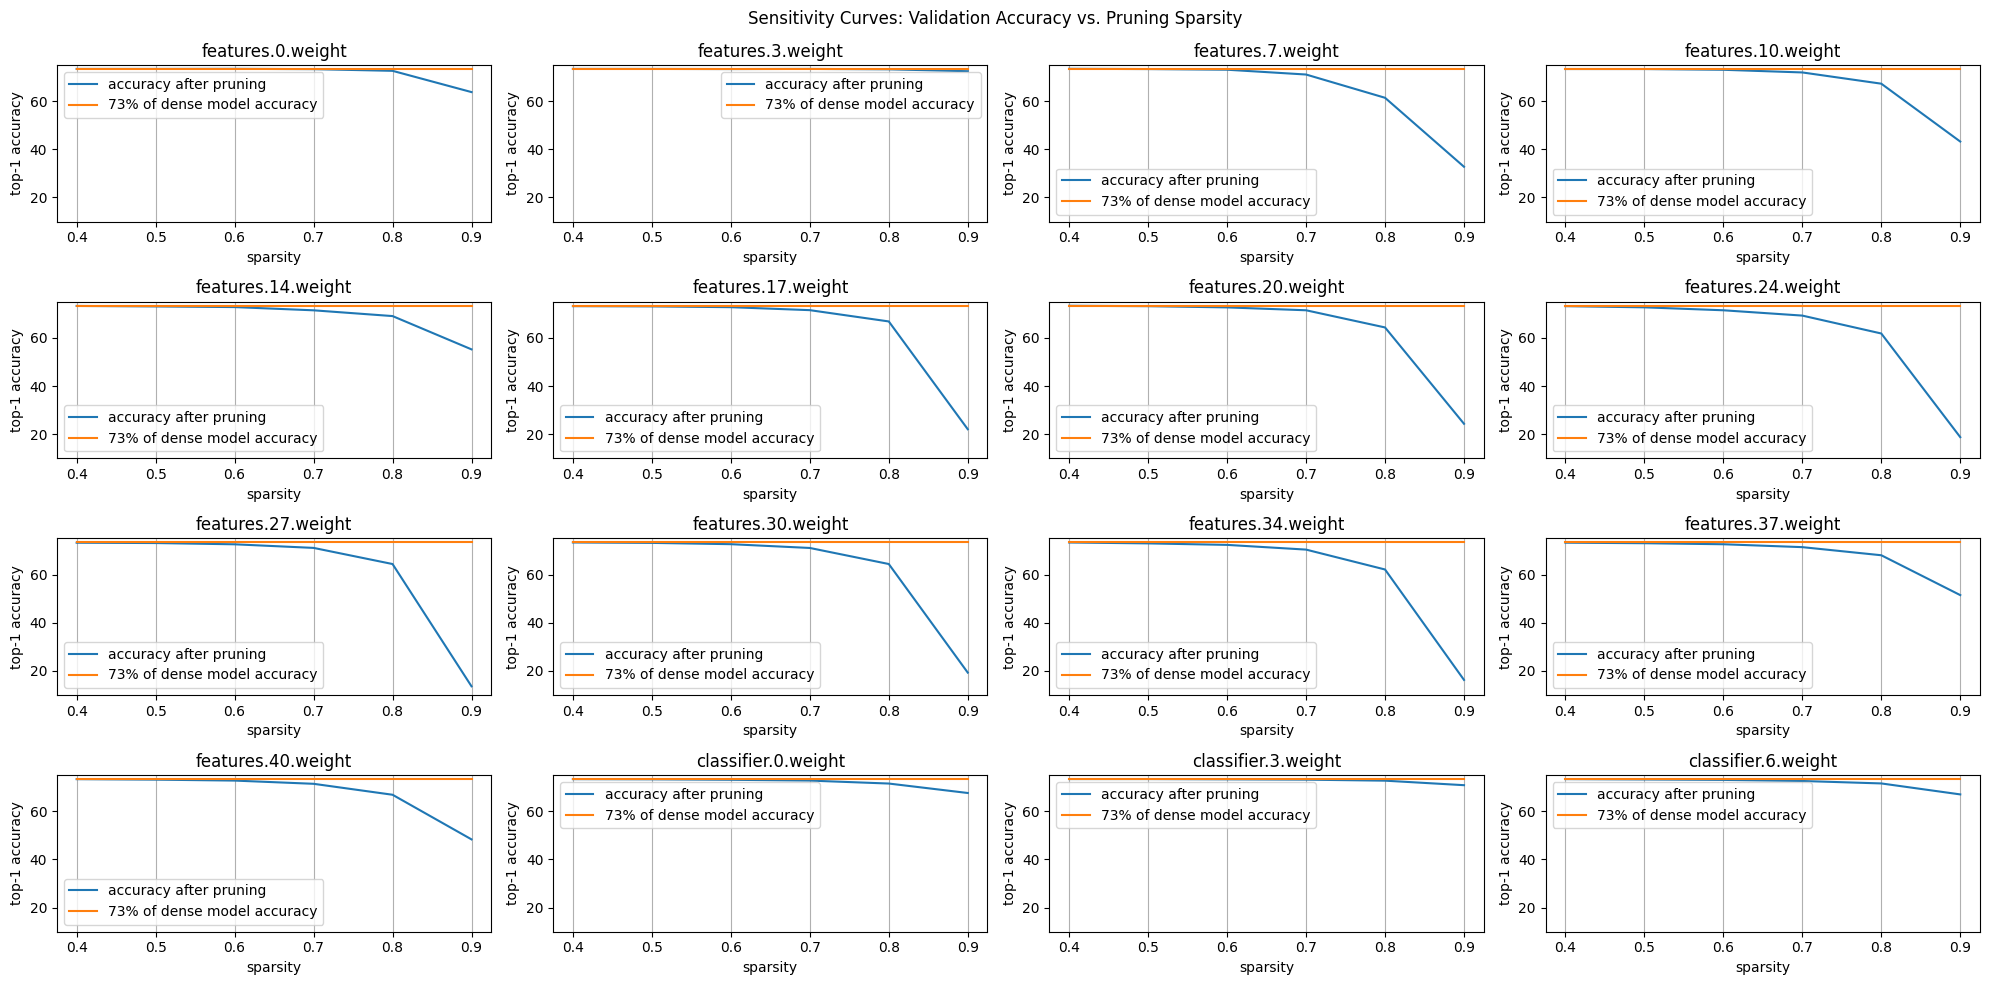

In [ ]:
def plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy):
    fig, axes = plt.subplots(4, int(math.ceil(len(accuracies) / 4)),figsize=(20,10))
    axes = axes.ravel()
    plot_index = 0
    for name, param in model.named_parameters():
        if param.dim() > 1:
            ax = axes[plot_index]
            curve = ax.plot(sparsities, accuracies[plot_index])
            line = ax.plot(sparsities, [dense_model_accuracy] * len(sparsities))
            ax.set_xticks(np.arange(start=0.4, stop=1.0, step=0.1))
            ax.set_ylim(60, 75)
            ax.set_title(name)
            ax.set_xlabel('sparsity')
            ax.set_ylabel('top-1 accuracy')
            ax.legend([
                'accuracy after pruning',
                f'{dense_model_accuracy:.0f}% of dense model accuracy'
            ])
            ax.grid(axis='x')
            plot_index += 1
    fig.suptitle('Sensitivity Curves: Validation Accuracy vs. Pruning Sparsity')
    fig.tight_layout()
    fig.subplots_adjust(top=0.925)
    plt.show()

plot_sensitivity_scan(sparsities, accuracies, dense_model_accuracy)

{'features.0.weight': 1728, 'features.3.weight': 36864, 'features.7.weight': 73728, 'features.10.weight': 147456, 'features.14.weight': 294912, 'features.17.weight': 589824, 'features.20.weight': 589824, 'features.24.weight': 1179648, 'features.27.weight': 2359296, 'features.30.weight': 2359296, 'features.34.weight': 2359296, 'features.37.weight': 2359296, 'features.40.weight': 2359296, 'classifier.0.weight': 102760448, 'classifier.3.weight': 16777216, 'classifier.6.weight': 4096000}


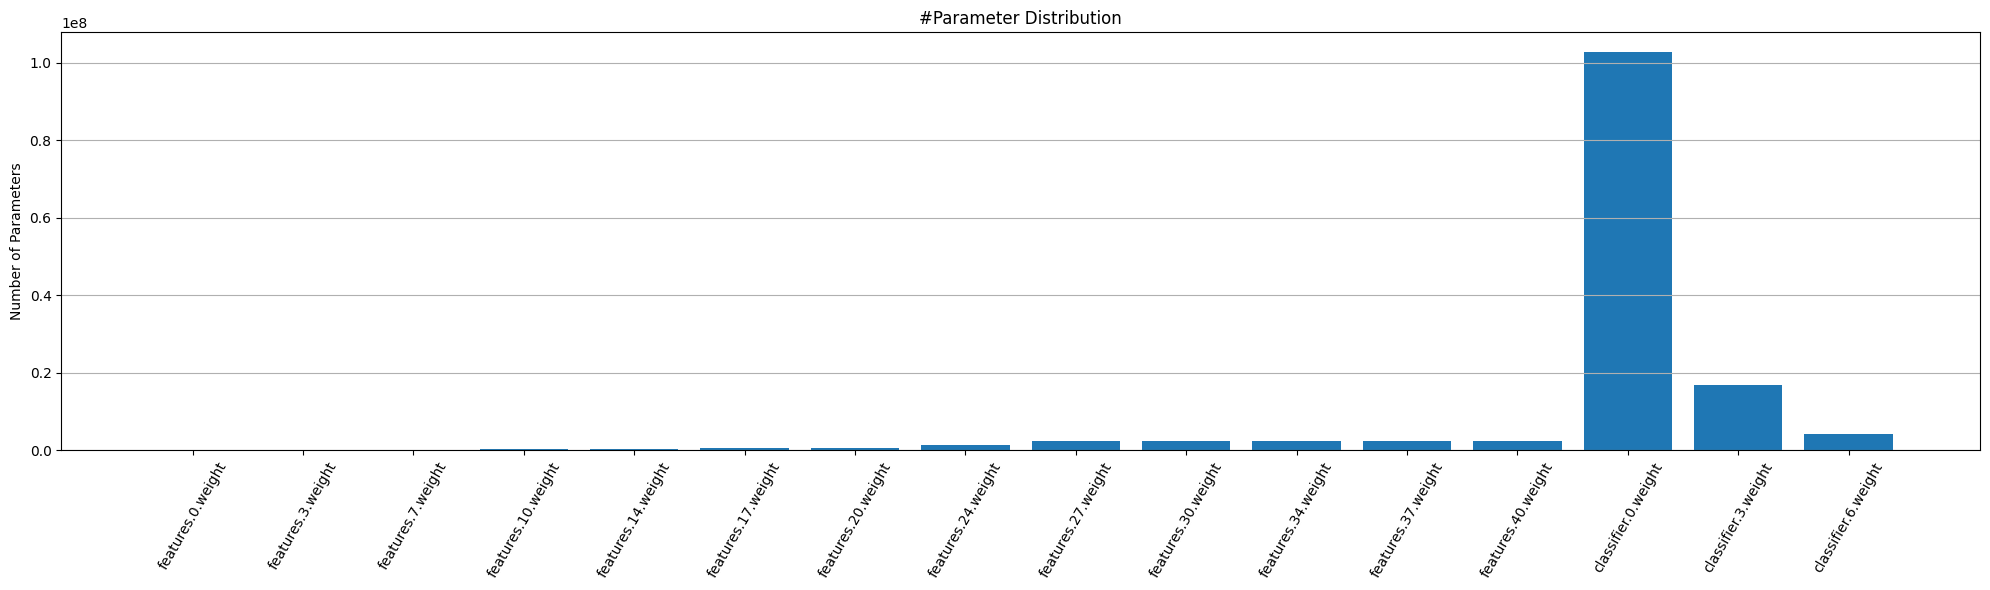

In [53]:
def plot_num_parameters_distribution(model):
    num_parameters = dict()
    for name, param in model.named_parameters():
        if param.dim() > 1:
            num_parameters[name] = param.numel()
    print(num_parameters)
    fig = plt.figure(figsize=(20, 6))
    plt.grid(axis='y')
    plt.bar(list(num_parameters.keys()), list(num_parameters.values()))
    plt.title('#Parameter Distribution')
    plt.ylabel('Number of Parameters')
    plt.xticks(rotation=60)
    plt.tight_layout()
    plt.show()

plot_num_parameters_distribution(model)

### Find the optimal sparsities and finetune the model

In [7]:

sp_list = [0.7, 0.8, 0.6, 0.6, 0.5, 0.5, 0.5, 0.4, 0.5, 0.5, 0.4, 0.5, 0.5, 0.6, 0.7, 0.6]
len(sp_list)

16

In [8]:
i = 0
optimal_sparsities = dict()
for (name, param) in model.named_parameters():
    if param.dim() > 1:
        optimal_sparsities[name] = sp_list[i]
        i += 1
optimal_sparsities

{'features.0.weight': 0.7,
 'features.3.weight': 0.8,
 'features.7.weight': 0.6,
 'features.10.weight': 0.6,
 'features.14.weight': 0.5,
 'features.17.weight': 0.5,
 'features.20.weight': 0.5,
 'features.24.weight': 0.4,
 'features.27.weight': 0.5,
 'features.30.weight': 0.5,
 'features.34.weight': 0.4,
 'features.37.weight': 0.5,
 'features.40.weight': 0.5,
 'classifier.0.weight': 0.6,
 'classifier.3.weight': 0.7,
 'classifier.6.weight': 0.6}

In [ ]:
def fine_grained_prune(tensor: torch.Tensor, sparsity : float) -> torch.Tensor:
    """
    magnitude-based pruning for single tensor
    :param tensor: torch.(cuda.)Tensor, weight of conv/fc layer
    :param sparsity: float, pruning sparsity
        sparsity = #zeros / #elements = 1 - #nonzeros / #elements
    :return:
        torch.(cuda.)Tensor, mask for zeros
    """
    sparsity = min(max(0.0, sparsity), 1.0)
    if sparsity == 1.0:
        tensor.zero_()
        return torch.zeros_like(tensor)
    elif sparsity == 0.0:
        return torch.ones_like(tensor)

    num_elements = tensor.numel()

    ##################### YOUR CODE STARTS HERE #####################
    # Step 1: calculate the #zeros (please use round())
    num_zeros = round(num_elements * sparsity)
    # Step 2: calculate the importance of weight
    importance = torch.abs(tensor)
    # Step 3: calculate the pruning threshold
    threshold = torch.kthvalue(importance.flatten(), num_zeros)[0]
    # Step 4: get binary mask (1 for nonzeros, 0 for zeros)
    mask = importance > threshold
    ##################### YOUR CODE ENDS HERE #######################

    # Step 5: apply mask to prune the tensor
    tensor.mul_(mask)

    return mask

class FineGrainedPruner:
    def __init__(self, model, sparsity_dict):
        self.masks = FineGrainedPruner.prune(model, sparsity_dict)

    @torch.no_grad()
    def apply(self, model):
        for name, param in model.named_parameters():
            if name in self.masks:
                param *= self.masks[name]

    @staticmethod
    @torch.no_grad()
    def prune(model, sparsity_dict):
        masks = dict()
        for name, param in model.named_parameters():
            if param.dim() > 1: # we only prune conv and fc weights
                masks[name] = fine_grained_prune(param, sparsity_dict[name])
        return masks

After pruning with sparsity dictionary
  features.0.weight: 0.70
  features.3.weight: 0.80
  features.7.weight: 0.60
  features.10.weight: 0.60
  features.14.weight: 0.50
  features.17.weight: 0.50
  features.20.weight: 0.50
  features.24.weight: 0.40
  features.27.weight: 0.50
  features.30.weight: 0.50
  features.34.weight: 0.40
  features.37.weight: 0.50
  features.40.weight: 0.50
  classifier.0.weight: 0.60
  classifier.3.weight: 0.70
  classifier.6.weight: 0.60
The sparsity of each layer becomes
  features.0.weight: 0.70
  features.3.weight: 0.80
  features.7.weight: 0.60
  features.10.weight: 0.60
  features.14.weight: 0.50
  features.17.weight: 0.50
  features.20.weight: 0.50
  features.24.weight: 0.40
  features.27.weight: 0.50
  features.30.weight: 0.50
  features.34.weight: 0.40
  features.37.weight: 0.50
  features.40.weight: 0.50
  classifier.0.weight: 0.60
  classifier.3.weight: 0.70
  classifier.6.weight: 0.60
Sparse model has size = 211.61 MiB = 40.09% of dense model siz

Sparse model has accuracy = 68.79% before fintuning


In [ ]:

pruner = FineGrainedPruner(model, optimal_sparsities, device=DEVICE)
print(f'After pruning with sparsity dictionary')
for name, sparsity in optimal_sparsities.items():
    print(f'  {name}: {sparsity:.2f}')
print(f'The sparsity of each layer becomes')
for name, param in model.named_parameters():
    if name in optimal_sparsities:
        print(f'  {name}: {get_sparsity(param):.2f}')

sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size = {sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
print(f"Sparse model has accuracy = {sparse_model_accuracy:.2f}% before fintuning")

# plot_weight_distribution(model, count_nonzero_only=True)

### Finetune the Fine-Grained Pruned Model

In [ ]:
num_finetune_epochs = 5
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()

best_sparse_model_checkpoint = dict()
best_accuracy = 0
print(f'Finetuning Fine-grained Pruned Sparse Model')
for epoch in range(num_finetune_epochs):
    # At the end of each train iteration, we have to apply the pruning mask
    #    to keep the model sparse during the training
    train(model, dataloader['train'], criterion, optimizer, scheduler,
          callbacks=[lambda: pruner.apply(model)])
    accuracy = evaluate(model, dataloader['test'])
    is_best = accuracy > best_accuracy
    if is_best:
        best_sparse_model_checkpoint['state_dict'] = copy.deepcopy(model.state_dict())
        best_accuracy = accuracy
    print(f'    Epoch {epoch+1} Accuracy {accuracy:.2f}% / Best Accuracy: {best_accuracy:.2f}%')

RuntimeError: Inference tensors cannot be saved for backward. To work around you can make a clone to get a normal tensor and use it in autograd.

: 

In [74]:
# load the best sparse model checkpoint to evaluate the final performance}
model = vgg16_bn(VGG16_BN_Weights)
# model.load_state_dict()
sparse_model_size = get_model_size(model, count_nonzero_only=True)
print(f"Sparse model has size={sparse_model_size / MiB:.2f} MiB = {sparse_model_size / dense_model_size * 100:.2f}% of dense model size")
sparse_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
print(f"Sparse model has accuracy={sparse_model_accuracy:.2f}% after fintuning")

/usr/lib/python3.10/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/lib/python3.10/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sparse model has size=527.82 MiB = 100.00% of dense model size


Sparse model has accuracy=73.38% after fintuning


### Channel Prunning

In [74]:
from pruning import ChannelPruner
channel_pruner = ChannelPruner()

dummy_input = torch.randn(1, 3, 32, 32).to(DEVICE)
pruned_model = channel_pruner.prune(model, prune_ratio=0.3).to(DEVICE)
pruned_macs = get_model_macs(pruned_model, dummy_input)
# assert pruned_macs == 305388064
# print('* Check passed. Right MACs for the pruned model.')

pruned_model_accuracy = evaluate(pruned_model, dataloader['test'], device=DEVICE)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")

pruned model has accuracy=0.10%


In [ ]:
pruned_model

In [ ]:
print('Before sorting...')
dense_model_accuracy = evaluate(model, dataloader['test'], device=DEVICE)
print(f"dense model has accuracy={dense_model_accuracy:.2f}%")

print('After sorting...')
sorted_model = channel_pruner.apply_channel_sorting(model)
sorted_model_accuracy = evaluate(sorted_model, dataloader['test'], device=DEVICE)
print(f"sorted model has accuracy={sorted_model_accuracy:.2f}%")

# make sure accuracy does not change after sorting, since it is
# equivalent transform
assert abs(sorted_model_accuracy - dense_model_accuracy) < 0.1
print('* Check passed.')

In [40]:
channel_pruning_ratio = 0.3  # pruned-out ratio

print(" * Without sorting...")
pruned_model = channel_pruner.prune(model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'], device=DEVICE)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


print(" * With sorting...")
sorted_model = channel_pruner.apply_channel_sorting(model)
pruned_model = channel_pruner.prune(sorted_model, channel_pruning_ratio)
pruned_model_accuracy = evaluate(pruned_model, dataloader['test'], device=DEVICE)
print(f"pruned model has accuracy={pruned_model_accuracy:.2f}%")


 * Without sorting...


pruned model has accuracy=0.10%
 * With sorting...


pruned model has accuracy=0.65%


In [1]:
num_finetune_epochs = 5
channel_pruning_ratio = 0.3
optimizer = torch.optim.SGD(pruned_model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_finetune_epochs)
criterion = nn.CrossEntropyLoss()
channel_pruned_model_state_dict = finetune(model,
                                           dataloader,
                                           criterion,
                                           optimizer,
                                           scheduler,
                                           pruner_method='channel',
                                           prune_ratio=channel_pruning_ratio,
                                           num_finetune_epochs=num_finetune_epochs,
                                           device=DEVICE)

NameError: name 'torch' is not defined

In [83]:
table_template = "{:<15} {:<15} {:<15} {:<15}"
print (table_template.format('', 'Original','Pruned','Reduction Ratio'))

# 1. measure the latency of the original model and the pruned model on CPU
#   which simulates inference on an edge device
dummy_input = torch.randn(1, 3, 32, 32).to('cpu')
pruned_model = pruned_model.to('cpu')
model = model.to('cpu')

pruned_latency = measure_latency(pruned_model, dummy_input)
original_latency = measure_latency(model, dummy_input)
print(table_template.format('Latency (ms)',
                            round(original_latency * 1000, 1),
                            round(pruned_latency * 1000, 1),
                            round(original_latency / pruned_latency, 1)))

# 2. measure the computation (MACs)
original_macs = get_model_macs(model, dummy_input)
pruned_macs = get_model_macs(pruned_model, dummy_input)
print(table_template.format('MACs (M)',
                            round(original_macs / 1e6),
                            round(pruned_macs / 1e6),
                            round(original_macs / pruned_macs, 1)))

# 3. measure the model size (params)
original_param = get_num_parameters(model)
pruned_param = get_num_parameters(pruned_model)
print(table_template.format('Param (M)',
                            round(original_param / 1e6, 2),
                            round(pruned_param / 1e6, 2),
                            round(original_param / pruned_param, 1)))

                Original        Pruned          Reduction Ratio


RuntimeError: Given weight of size [45, 3, 3, 3], expected bias to be 1-dimensional with 45 elements, but got bias of size [64] instead